In [27]:
# Setup
import json
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap

# Paths
PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
ARCHIVE_DIR = DATA_DIR / 'archive' / 'medpix_data_final' / 'medpix_data_final'
PROCESSED_DIR = DATA_DIR / 'processed'
FEATURES_DIR = DATA_DIR / 'features'

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Features will be saved to: {FEATURES_DIR}")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Using device: {device}")

✅ Project root: /home/yousef/code/school/4DT911-project
✅ Features will be saved to: /home/yousef/code/school/4DT911-project/data/features

🖥️  Using device: cuda


In [28]:
# Load unique cases (v2)
print("\n📂 Loading cases_cleaned_v2.json...")
with open(PROCESSED_DIR / 'cases_cleaned_v2.json') as f:
    cases = json.load(f)

print(f"✅ Loaded {len(cases)} unique cases")

# Filter cases that have actual image folders on disk
print("\n🔍 Checking which cases have images on disk...")
cases_with_images = []

for case in cases:
    case_id = case['id']
    # Case folders have 'case_' prefix
    case_folder = ARCHIVE_DIR / f"case_{case_id}"
    
    # Check if folder exists
    if case_folder.exists() and case_folder.is_dir():
        # Get all image files in the folder
        image_files = [
            f.name for f in case_folder.iterdir() 
            if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
        ]
        
        if image_files:
            # Add imagePaths field to case
            case['imagePaths'] = image_files
            cases_with_images.append(case)

print(f"✅ Cases with images: {len(cases_with_images)}")
if cases_with_images:
    print(f"   Sample case has {len(cases_with_images[0]['imagePaths'])} images")


📂 Loading cases_cleaned_v2.json...
✅ Loaded 5872 unique cases✅ Loaded 5872 unique cases

🔍 Checking which cases have images on disk...


🔍 Checking which cases have images on disk...
✅ Cases with images: 5866
   Sample case has 23 images
✅ Cases with images: 5866
   Sample case has 23 images


In [29]:
# Load Medical CLIP model
print("\n📥 Loading medical CLIP model...")
print("   This may download the model on first run...")

from transformers import CLIPProcessor, CLIPModel

# Using PubMedCLIP - a CLIP model trained on medical images from PubMed
model_name = "flaviagiammarino/pubmed-clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model = model.to(device)
model.eval()

print(f"✅ PubMedCLIP model loaded")
print(f"   Model: {model_name}")
print(f"   Embedding dimension: {model.config.projection_dim}")


📥 Loading medical CLIP model...
   This may download the model on first run...
✅ PubMedCLIP model loaded
   Model: flaviagiammarino/pubmed-clip-vit-base-patch32
   Embedding dimension: 512
✅ PubMedCLIP model loaded
   Model: flaviagiammarino/pubmed-clip-vit-base-patch32
   Embedding dimension: 512


In [31]:
# Feature extraction function
def extract_medclip_features(image_path, model, processor, device):
    """
    Extract MedCLIP features from an image
    """
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)
        
        # Extract features
        with torch.no_grad():
            vision_outputs = model.vision_model(pixel_values=pixel_values)
            pooled_output = vision_outputs.pooler_output
            image_embeds = model.visual_projection(pooled_output)
            
            # L2 normalize
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            
        return image_embeds.cpu().numpy().flatten()
        
    except Exception as e:
        print(f"⚠️  Error extracting features from {image_path}: {e}")
        return None

# Test only if we have cases with images
if len(cases_with_images) > 0:
    test_case = cases_with_images[0]
    # Use case_ prefix for folder name and imagePaths field
    test_img_path = ARCHIVE_DIR / f"case_{test_case['id']}" / test_case['imagePaths'][0]
    
    print(f"\n🧪 Testing with case: {test_case['id']}")
    print(f"   Image path: {test_img_path}")
    print(f"   Path exists: {test_img_path.exists()}")
    
    test_features = extract_medclip_features(test_img_path, model, processor, device)
    
    if test_features is not None:
        print(f"\n✅ Feature extraction working!")
        print(f"   Feature shape: {test_features.shape}")
    else:
        print("\n❌ Feature extraction failed")
else:
    print("\n⚠️  Cannot test - no cases with images found!")


🧪 Testing with case: 8892378009084536600
   Image path: /home/yousef/code/school/4DT911-project/data/archive/medpix_data_final/medpix_data_final/case_8892378009084536600/image_10.jpg
   Path exists: True

✅ Feature extraction working!
   Feature shape: (512,)

✅ Feature extraction working!
   Feature shape: (512,)


In [32]:
# Extract features for all cases
print("\n🔄 Extracting MedCLIP features for all cases...")
print(f"   Processing {len(cases_with_images)} cases...")

image_embeddings = []
case_metadata = []
failed_cases = []

for case in tqdm(cases_with_images, desc="Extracting features"):
    case_id = case['id']
    image_paths = case.get('imagePaths', [])
    
    if not image_paths:
        continue
    
    # Extract from first image - use case_ prefix for folder
    img_path = ARCHIVE_DIR / f"case_{case_id}" / image_paths[0]
    features = extract_medclip_features(img_path, model, processor, device)
    
    if features is not None:
        image_embeddings.append(features)
        case_metadata.append({
            'case_id': case_id,
            'diagnosis': case.get('diagnosis'),
            'image_count': len(image_paths)
        })
    else:
        failed_cases.append(case_id)

image_embeddings = np.array(image_embeddings)

print(f"\n✅ Extraction complete!")
print(f"   Successful: {len(image_embeddings)}")
print(f"   Failed: {len(failed_cases)}")
print(f"   Shape: {image_embeddings.shape}")


🔄 Extracting MedCLIP features for all cases...
   Processing 5866 cases...


Extracting features: 100%|██████████| 5866/5866 [01:29<00:00, 65.35it/s]


✅ Extraction complete!
   Successful: 5866
   Failed: 0
   Shape: (5866, 512)



📊 Finding optimal number of clusters...
k=10: Silhouette=0.180, DB=2.095, Inertia=1002.3
k=10: Silhouette=0.180, DB=2.095, Inertia=1002.3
k=15: Silhouette=0.176, DB=2.076, Inertia=894.2
k=15: Silhouette=0.176, DB=2.076, Inertia=894.2
k=20: Silhouette=0.169, DB=2.027, Inertia=825.4
k=20: Silhouette=0.169, DB=2.027, Inertia=825.4
k=25: Silhouette=0.165, DB=2.017, Inertia=766.0
k=25: Silhouette=0.165, DB=2.017, Inertia=766.0
k=30: Silhouette=0.168, DB=2.025, Inertia=729.0
k=30: Silhouette=0.168, DB=2.025, Inertia=729.0


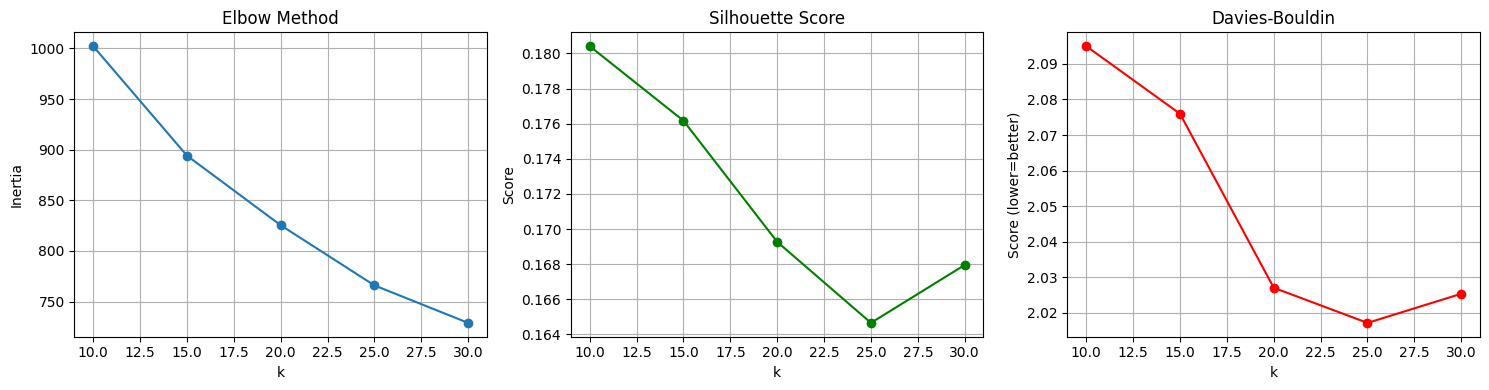

In [33]:
# Find optimal k for clustering
print("\n📊 Finding optimal number of clusters...")

k_values = [10, 15, 20, 25, 30]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(image_embeddings)
    
    sil = silhouette_score(image_embeddings, labels)
    db = davies_bouldin_score(image_embeddings, labels)
    
    results.append({'k': k, 'silhouette': sil, 'davies_bouldin': db, 'inertia': kmeans.inertia_})
    print(f"k={k}: Silhouette={sil:.3f}, DB={db:.3f}, Inertia={kmeans.inertia_:.1f}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot([r['k'] for r in results], [r['inertia'] for r in results], 'o-')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

axes[1].plot([r['k'] for r in results], [r['silhouette'] for r in results], 'o-', color='green')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Score')
axes[1].grid(True)

axes[2].plot([r['k'] for r in results], [r['davies_bouldin'] for r in results], 'o-', color='red')
axes[2].set_title('Davies-Bouldin')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Score (lower=better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [34]:
# Final clustering with k=25
print("\n🎯 Final clustering with k=25...")

optimal_k = 25
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(image_embeddings)

print(f"✅ Clustered into {optimal_k} groups")

# Cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
print(f"\nCluster distribution:")
for cid, cnt in zip(unique, counts):
    print(f"  Cluster {cid}: {cnt} cases")


🎯 Final clustering with k=25...
✅ Clustered into 25 groups

Cluster distribution:
  Cluster 0: 266 cases
  Cluster 1: 402 cases
  Cluster 2: 181 cases
  Cluster 3: 386 cases
  Cluster 4: 272 cases
  Cluster 5: 228 cases
  Cluster 6: 198 cases
  Cluster 7: 303 cases
  Cluster 8: 402 cases
  Cluster 9: 133 cases
  Cluster 10: 107 cases
  Cluster 11: 327 cases
  Cluster 12: 182 cases
  Cluster 13: 134 cases
  Cluster 14: 158 cases
  Cluster 15: 167 cases
  Cluster 16: 372 cases
  Cluster 17: 288 cases
  Cluster 18: 107 cases
  Cluster 19: 326 cases
  Cluster 20: 294 cases
  Cluster 21: 148 cases
  Cluster 22: 167 cases
  Cluster 23: 181 cases
  Cluster 24: 137 cases
✅ Clustered into 25 groups

Cluster distribution:
  Cluster 0: 266 cases
  Cluster 1: 402 cases
  Cluster 2: 181 cases
  Cluster 3: 386 cases
  Cluster 4: 272 cases
  Cluster 5: 228 cases
  Cluster 6: 198 cases
  Cluster 7: 303 cases
  Cluster 8: 402 cases
  Cluster 9: 133 cases
  Cluster 10: 107 cases
  Cluster 11: 327 cases

In [35]:
# UMAP dimensionality reduction
print("\n🗺️  Creating UMAP visualization...")

reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine'
)

umap_coords = reducer.fit_transform(image_embeddings)

print(f"✅ UMAP complete!")
print(f"   Shape: {umap_coords.shape}")
print(f"   X range: [{umap_coords[:, 0].min():.2f}, {umap_coords[:, 0].max():.2f}]")
print(f"   Y range: [{umap_coords[:, 1].min():.2f}, {umap_coords[:, 1].max():.2f}]")


🗺️  Creating UMAP visualization...


/home/yousef/code/school/4DT911-project/Ml-Notebook/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP complete!
   Shape: (5866, 2)
   X range: [-10.48, 16.81]
   Y range: [-6.63, 19.08]


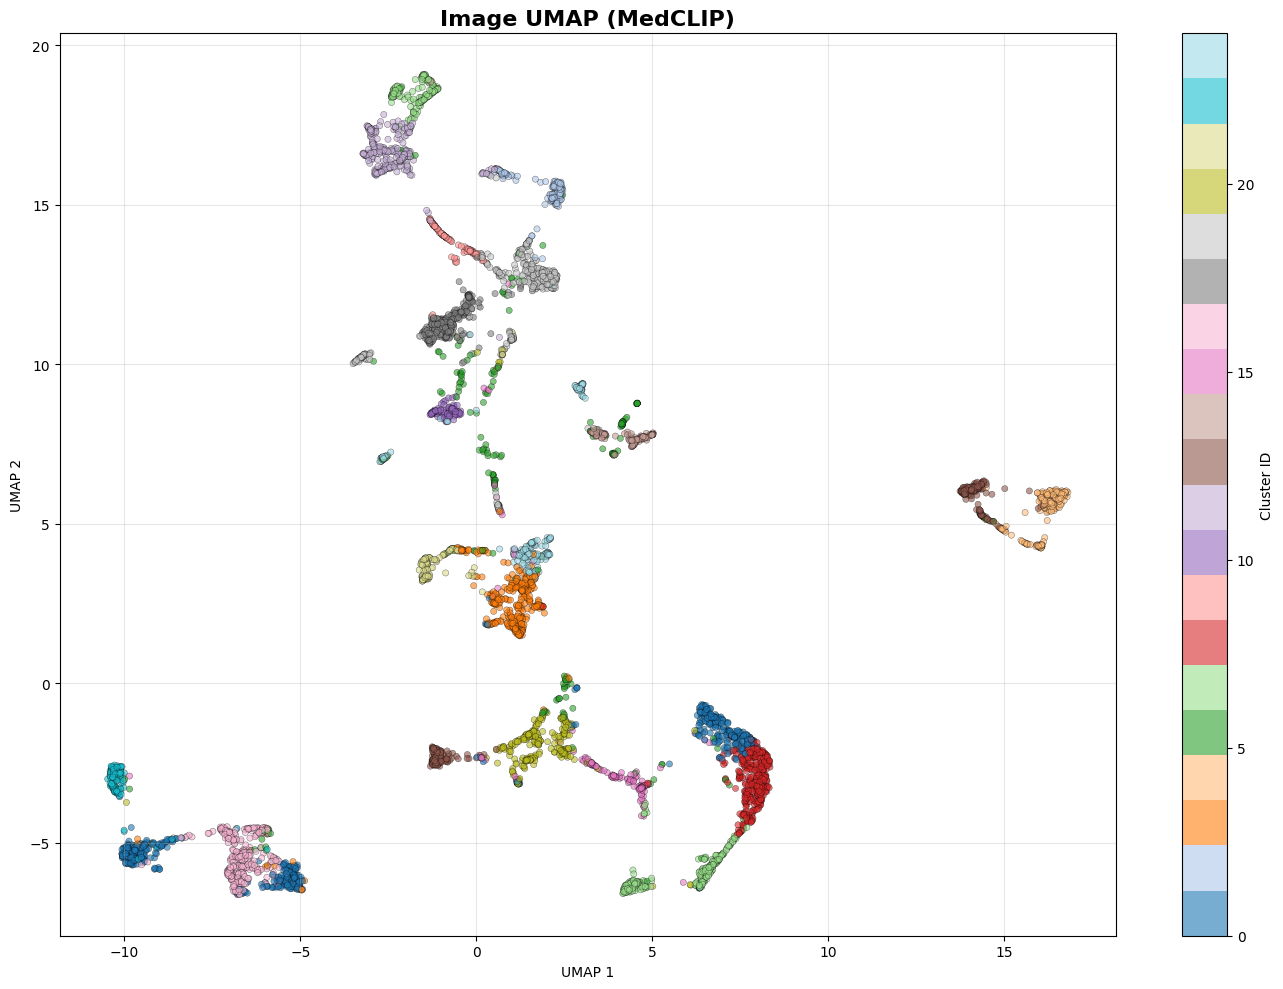

In [36]:
# Visualize UMAP
plt.figure(figsize=(14, 10))

scatter = plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    c=cluster_labels,
    cmap='tab20',
    s=20,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3
)

plt.colorbar(scatter, label='Cluster ID')
plt.title('Image UMAP (MedCLIP)', fontsize=16, fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
# Calculate diagnosis frequencies
diagnosis_counts = {}
for case in cases:
    diag = case.get('diagnosis')
    if diag:
        diagnosis_counts[diag] = diagnosis_counts.get(diag, 0) + 1

# Get diagnoses and frequencies for metadata
diagnoses = [meta['diagnosis'] for meta in case_metadata]
frequencies = [diagnosis_counts.get(d, 1) for d in diagnoses]

print(f"\n✅ Frequency range: {min(frequencies)} - {max(frequencies)}")


✅ Frequency range: 1 - 32


In [38]:
# Save results
print("\n💾 Saving results...")

# 1. Save cluster assignments
output_clusters = {
    "diagnoses": diagnoses,
    "clusters": cluster_labels.tolist()
}

with open(FEATURES_DIR / 'diagnosis_image_clusters.json', 'w') as f:
    json.dump(output_clusters, f, indent=2)
print(f"✅ Saved: diagnosis_image_clusters.json")

# 2. Save UMAP coordinates
output_umap = {
    "diagnoses": diagnoses,
    "clusters": cluster_labels.tolist(),
    "frequencies": frequencies,
    "umap_x": umap_coords[:, 0].tolist(),
    "umap_y": umap_coords[:, 1].tolist()
}

with open(FEATURES_DIR / 'diagnosis_umap_coords_image.json', 'w') as f:
    json.dump(output_umap, f, indent=2)
print(f"✅ Saved: diagnosis_umap_coords_image.json")

# 3. Save embeddings
np.save(FEATURES_DIR / 'image_embeddings_medclip.npy', image_embeddings)
print(f"✅ Saved: image_embeddings_medclip.npy")

# 4. Save metadata
metadata_output = {
    'model': model_name,
    'embedding_dim': int(image_embeddings.shape[1]),
    'num_cases': len(image_embeddings),
    'num_clusters': optimal_k,
    'device': str(device),
    'case_metadata': case_metadata,
    'failed_cases': failed_cases
}

with open(FEATURES_DIR / 'image_metadata_medclip.json', 'w') as f:
    json.dump(metadata_output, f, indent=2)
print(f"✅ Saved: image_metadata_medclip.json")

# 5. Placeholder labels
cluster_labels_dict = {
    "cluster_labels": {str(i): f"Image Cluster {i}" for i in range(optimal_k)}
}

with open(FEATURES_DIR / 'cluster_labels_image.json', 'w') as f:
    json.dump(cluster_labels_dict, f, indent=2)
print(f"✅ Saved: cluster_labels_image.json")

print("\n🎉 All done! Image UMAP ready for frontend integration.")


💾 Saving results...
✅ Saved: diagnosis_image_clusters.json
✅ Saved: diagnosis_umap_coords_image.json
✅ Saved: image_embeddings_medclip.npy
✅ Saved: image_metadata_medclip.json
✅ Saved: cluster_labels_image.json

🎉 All done! Image UMAP ready for frontend integration.
